#GAT Using Default values: gossipcop and BERT

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-+.html
Looking in links: https://data.pyg.org/whl/torch-+.html


In [ ]:
from torch_geometric.datasets import UPFD  #importing the UPFD Dataset

In [ ]:
from torch_geometric.datasets import UPFD
train_data = UPFD(root=".", name="gossipcop", feature="bert", split="train")
test_data = UPFD(root=".", name="gossipcop", feature="bert", split="test")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))

Train Samples:  1092
Test Samples:  3826


In [ ]:
sample_id=1
train_data[sample_id].edge_index

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  15,  15,  17,  17,
          22,  22,  22,  22,  23,  26,  26,  26,  26,  26,  26,  26,  26,  27,
          27,  27,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
          28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
          28,  28,  28,  28,  28,  28,  28,  28,  30,  34,  34,  38,  38,  38,
          38,  39,  40,  57,  59,  65,  65,  65,  66,  68,  69,  77,  77,  79,
          79,  80,  83,  83,  83,  83,  84, 101, 110, 115, 116, 117],
        [  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
          15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  43,  44,
          45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  5

In [ ]:
"""
Had to import this "manually" due to some errors.
"""

!pip install networkx
import networkx as nx

# From PyG utils
def to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=False,
                remove_self_loops=False):
    if to_undirected:
        G = nx.Graph()
    else:
        G = nx.DiGraph()
    G.add_nodes_from(range(data.num_nodes))
    node_attrs, edge_attrs = node_attrs or [], edge_attrs or []
    values = {}
    for key, item in data(*(node_attrs + edge_attrs)):
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()
        else:
            values[key] = item
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = item[0]
    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        if to_undirected and v > u:
            continue
        if remove_self_loops and u == v:
            continue
        G.add_edge(u, v)
        for key in edge_attrs:
            G[u][v][key] = values[key][i]
    for key in node_attrs:
        for i, feat_dict in G.nodes(data=True):
            feat_dict.update({key: values[key][i]})
    return G

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import LeakyReLU, Softmax, Linear, SELU,Dropout
from torch_geometric.nn import SAGEConv, global_max_pool, GATv2Conv, TopKPooling, global_mean_pool
from torch_geometric.transforms import ToUndirected
from torch.nn import LeakyReLU


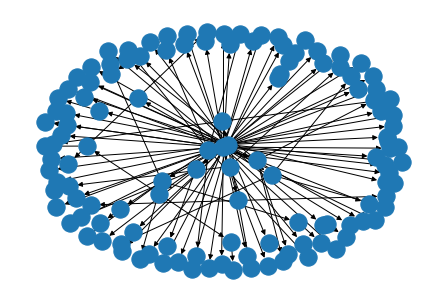

In [ ]:
nx.draw(to_networkx(train_data[sample_id]))

In [ ]:
print(train_data[sample_id].x.shape)
train_data[sample_id].x

torch.Size([125, 768])


tensor([[-0.0895, -0.0141, -0.2686,  ...,  0.1738,  0.3480,  0.1831],
        [ 0.0600,  0.0440,  0.0087,  ...,  0.4195,  0.0239,  0.5018],
        [ 0.1362, -0.0738,  0.0080,  ...,  0.3674, -0.1551,  0.3255],
        ...,
        [-0.0284,  0.2227,  0.0766,  ...,  0.5024, -0.0791,  0.7929],
        [-0.0515,  0.1556,  0.2712,  ...,  0.4764,  0.0087,  0.4305],
        [ 0.0070,  0.1475,  0.0915,  ...,  0.5039, -0.0133,  0.6324]])

<AxesSubplot:>

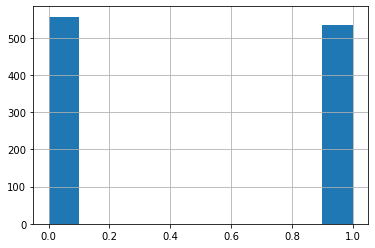

In [ ]:
import pandas as pd
labels = [data.y.item() for i, data in enumerate(train_data)]
df = pd.DataFrame(labels, columns=["Labels"])
df["Labels"].hist()

##Loading Dataset Using DataLoader for train data and test data of gossipcop

In [ ]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

##Defining Architecture of GAT Using 3 GAT Convolutional layers  with 3 unit MLP

In [ ]:
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GATConv
from torch.nn import Linear


class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        # Graph Convolutions
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)

        # Readout
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()

        # Pooling
        h = gmp(h, batch)

        # Readout
        h = self.lin0(h).relu()

        # According to UPFD paper: Include raw word2vec embeddings of news 
        # This is done per graph in the batch
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        # root is e.g. [   0,   14,   94,  171,  230,  302, ... ]
        news = x[root]
        news = self.lin_news(news).relu()
        
        out = self.lin1(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)

GNN(train_data.num_features, 128, 1)

GNN(
  (conv1): GATConv(768, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (lin_news): Linear(in_features=768, out_features=128, bias=True)
  (lin0): Linear(in_features=128, out_features=128, bias=True)
  (lin1): Linear(in_features=256, out_features=1, bias=True)
)

##Train and Test of model using Hyperparameters

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01) #using adam optimiser and the learning rate as lr= 0.0001
loss_fnc = torch.nn.BCELoss()#binary cross entropy loss

def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())

    # Calculate Metrics
    accuracy, f1 = metrics(all_preds, all_labels)

    return total_loss / len(test_loader.dataset), accuracy, f1


def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts)
    return acc, f1

In [ ]:
import matplotlib.pyplot as plt

wloss = []
weighted_loss = 0
exp_param = 0.8
best_test_loss = float('inf')  # Initialize with a large value

best_test_acc = 0
best_epoch = 0
test_acc_values = []

for epoch in range(500):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    weighted_loss = exp_param * weighted_loss + (1 - exp_param) * (test_loss / len(test_loader.dataset))
  
    wloss.append(weighted_loss / (1 - exp_param ** (epoch + 1)))
    
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_epoch = epoch
    
    test_acc_values.append(test_acc)
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss  # Update the best test loss

    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.5f} | '
          f'TestLoss: {test_loss:.5f} | TestAcc: {test_acc:.5f} | TestF1: {test_f1:.2f}')

# Print the best values
best_wloss = min(wloss)
best_epoch_wloss = wloss.index(best_wloss)
print(f'Best WLoss: {best_wloss:.5f} | Best Epoch (WLoss): {best_epoch_wloss}')
print(f'Best Test Accuracy: {best_test_acc:.5f} | Best Epoch (Test Accuracy): {best_epoch}')

Epoch: 00 |  TrainLoss: 0.80798 | TestLoss: 0.66336 | TestAcc: 0.62258 | TestF1: 0.70
Epoch: 01 |  TrainLoss: 0.63877 | TestLoss: 0.61403 | TestAcc: 0.69106 | TestF1: 0.63
Epoch: 02 |  TrainLoss: 0.58237 | TestLoss: 0.64464 | TestAcc: 0.65395 | TestF1: 0.49
Epoch: 03 |  TrainLoss: 0.58743 | TestLoss: 0.55995 | TestAcc: 0.72582 | TestF1: 0.71
Epoch: 04 |  TrainLoss: 0.54372 | TestLoss: 0.55250 | TestAcc: 0.72190 | TestF1: 0.71
Epoch: 05 |  TrainLoss: 0.52970 | TestLoss: 0.55637 | TestAcc: 0.70857 | TestF1: 0.73
Epoch: 06 |  TrainLoss: 0.54181 | TestLoss: 0.54556 | TestAcc: 0.73340 | TestF1: 0.72
Epoch: 07 |  TrainLoss: 0.54687 | TestLoss: 0.55489 | TestAcc: 0.72844 | TestF1: 0.69
Epoch: 08 |  TrainLoss: 0.51259 | TestLoss: 0.54437 | TestAcc: 0.72086 | TestF1: 0.73
Epoch: 09 |  TrainLoss: 0.49640 | TestLoss: 0.54157 | TestAcc: 0.72896 | TestF1: 0.72
Epoch: 10 |  TrainLoss: 0.51132 | TestLoss: 0.54291 | TestAcc: 0.71668 | TestF1: 0.73
Epoch: 11 |  TrainLoss: 0.51628 | TestLoss: 0.53517 | 

##Plot of Test Accuracy over best Loss and Best Accuracy Epoch

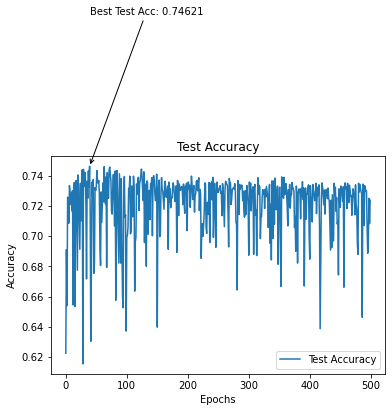

In [ ]:
# Plotting the test accuracy
epochs = range(500)
plt.plot(epochs, test_acc_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

# Marking the best test accuracy
plt.annotate(f'Best Test Acc: {best_test_acc:.5f}', xy=(best_epoch, best_test_acc),
             xytext=(best_epoch, best_test_acc + 0.1),
             arrowprops=dict(facecolor='red', arrowstyle='->'))

plt.show()